# Wine Value Analysis

The goal of this analysis is to find **value wines** and their main characteristics. In particular, we are interested to know which ***countries***, ***regions*** and ***grape varieties*** we should pay attention to in our search for value wines.

## Wine value definition

First, we need to define *value* in wine since there is no universal definition of that. In general, the greater the wine (higher tasting points) and lower the price - the more value the wine has. 

Let's introduce a concept of *wine value scores*. The scores are calculated using a simple function of wine tasting points and price. The higher the tasting points and lower the price - the higher the value score. To give a better sense of the scores, the matrix below shows the value scores to different points and price.

In [1]:
import math 

print('Matrix of wine value scores: rows = price, columns = tasting points', '\n')

print('  ', end = '  ')

for points in range(80,101):
    print(points, end=' ')
print('\n')

for price in range(10,100,5):
    print(price, end='  ')
    
    for points in range(80,101):
        value = int((points-70)/math.log(price,10))
        if value <= 10:
            print(10, end = ' ')
        else:
            print(value, end = ' ')
    print()

Matrix of wine value scores: rows = price, columns = tasting points 

    80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
15  10 10 10 11 11 12 13 14 15 16 17 17 18 19 20 21 22 22 23 24 25 
20  10 10 10 10 10 11 12 13 13 14 15 16 16 17 18 19 19 20 21 22 23 
25  10 10 10 10 10 10 11 12 12 13 14 15 15 16 17 17 18 19 20 20 21 
30  10 10 10 10 10 10 10 11 12 12 13 14 14 15 16 16 17 18 18 19 20 
35  10 10 10 10 10 10 10 11 11 12 12 13 14 14 15 16 16 17 18 18 19 
40  10 10 10 10 10 10 10 10 11 11 12 13 13 14 14 15 16 16 17 18 18 
45  10 10 10 10 10 10 10 10 10 11 12 12 13 13 14 15 15 16 16 17 18 
50  10 10 10 10 10 10 10 10 10 11 11 12 12 13 14 14 15 15 16 17 17 
55  10 10 10 10 10 10 10 10 10 10 11 12 12 13 13 14 14 15 16 16 17 
60  10 10 10 10 10 10 10 10 10 10 11 11 12 12 13 14 14 15 15 16 16 
65  10 10 10 10 10 10 10 10 10 10 11 11 12 12 13 13 14 14 15 15 16 
70  10 10 10 10 10 10 10 10 10 10 10 11 11 1

Let's arbitrary decide that wines with scores 14 and higher are ***value wines*** and those with lower scores are not.

## Assigning value scores to the data

Now we apply this concept to the wines in the dataset and calculate their value scores.
First, we import the libraries, read and prepare the data.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.rename(columns={"Unnamed: 0": "id"}, inplace=True)
df.drop_duplicates(subset = df.columns.difference(['id']), inplace=True)

We create a new column *'value_score'*, which we calculate using the formula discussed above. Before applying the formula, we need to make sure the dependent columns don't have missing values. From the data exploration step that we've done earlier (see respective notebook in this repo), we know that *'price'* column has some missing values. At this point we deal with them by simply dropping the rows.

In [4]:
df = df.dropna(subset=['price'])
df['value_score'] = ((df['points']-70)/np.log10(df['price'])).round(0).astype(int)

The code below helps us to explore the disctribution of the new column. We can see that it's bell-shaped and centered around score 13.

<AxesSubplot:ylabel='Frequency'>

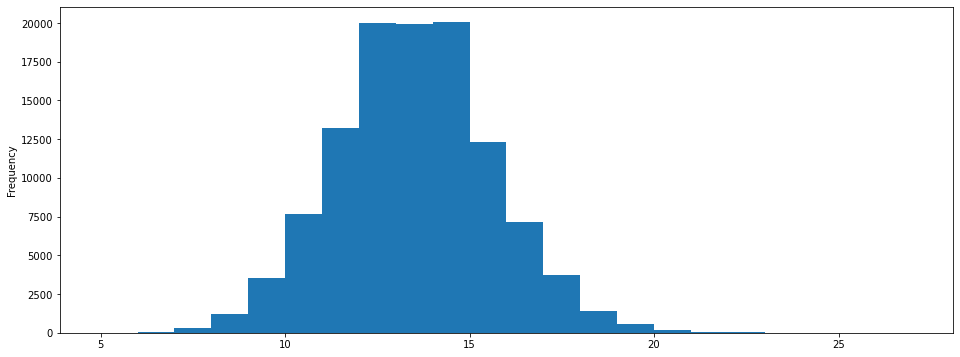

In [5]:
# df.value_score.describe()

# byvalue = df.groupby('value_score')[['id']].count()
# byvalue.sort_values('value_score')

df['value_score'].plot.hist(bins = 22, figsize = (16,6))

For convenience, we add one more column *'is_value'* flagging value wines. Remember, we decided that these are wines with scores 14 and higher.

In [6]:
df['is_value'] = np.where(df.value_score >= 14, 1, 0)

In the next two cells we compare basic statistics for value and non-value wines. 

First, we see that in our dataset we got ~46K value wines and ~66K - non-value ones (numbers are not the same, but comparable and big enough to make statistics reliable).

In terms of tasting points, both groups of wines are similar (value wines have only slightly higher points). This makes sense because value wines don't imply highter quality wines; they imply quality wines at lower prices. Both groups have wines of various quality (various tasting points).

So expectedly in terms of prices, value wines are cheaper: for example, the median is at USD 18 and max = USD 150 (for non-value they are 35 and 3300 respectively).

Again, these numbers make perfect sense and is exactly what we expected when we designed the value score formula.

In [7]:
df[df.is_value == 1][['points','price']].describe()

,points,price
count,45610.000000,45610.000000
mean,89.087722,21.373712
std,2.678576,11.317546
min,80.000000,4.000000
25%,87.000000,14.000000
50%,89.000000,18.000000
75%,91.000000,25.000000
max,100.000000,150.000000


In [8]:
df[df.is_value == 0][['points','price']].describe()

,points,price
count,65983.000000,65983.000000
mean,87.948244,45.468848
std,3.278696,51.694147
min,80.000000,6.000000
25%,86.000000,22.000000
50%,88.000000,35.000000
75%,90.000000,55.000000
max,100.000000,3300.000000


## Getting insights

Now we want to find which countries, regions and grape varieties stand out in our value conversation. When you're looking for a value wine, where should you start?

In the next sell we define a function that will help with this analysis. The function groups the data by a parameter of your interest (for example, country) and shows what percent of all wines (from this country) are value wines. The higher this percent - the better. Threshold can help filter out underrepresented groups to make conclusions more reliable (for example, show only countries that have at least 100 wines in the dataset).

In [9]:
def perc_value(df, col, tresh):
    d = df.groupby([col,'is_value'])[['id']].count()
    d = d.pivot_table(index = col, columns = 'is_value', values = 'id')
    d.rename(columns={0:'non-value', 1:'value'},inplace= True)

    d['all'] = d['non-value'] + d['value']
    d = d[d['all'] > tresh]

    d['%_non-value'] = d['non-value']*100 / d['all']
    d['%_value'] = d['value']*100 / d['all']
    d['%_diff'] = d['%_value'] - d['%_non-value']
    return d.sort_values('%_diff', ascending = False)

After applying the function to the *'country'* column and filtering out countries with fewer than 100 wines, we can make the following observations:
- ***Bulgaria***, ***Romania***, ***Portugal*** and ***Austria*** have most of their wines as value wines (90%-67%). There are other countires with high percent of value wines, but these have the most impressive results.
- On the other hand, ***US*** and ***Italy*** have most of their wines as non-value wines (67%-65%). Again, there are more countries in this list.

It's very important to take these and following observations with a grain of salt and view them from a standpoint of only a US consumer. For example, there might be several layers of selection biases: only a small number of, say, Bulgarian wines get imported to the US and even smaller number of them get reviewed by the Wine Enthusiast folks (and I'm not completely sure how they select wines for review). Highly probable that only the best and relatively cheap Bulgarian wines are imported (hence, the value) to maximize the number of sales. On the other hand, US wines don't have this import bias. Take also into account the fact that there are 50k US wines in the dataset and only 132 Bulgarian. On the other hand, you can probably relatively fairly compare Bulgaria and Hungary from this standpoint - they almost equally represented in the dataset and wines for both are imported. In any case, it's only correct to apply the observations by a US consumer in a US wine store.

For me personally, it's interesting to find Austria in the list of top "value" countries. I'll pay more attention to it from now on and will try to validate the results in practice. In the past, I always thought of Spain when looking for value, but here Spain has a nearly 50/50 split in value/non-value.

In [10]:
perc_value(df, 'country', 100)

is_value,non-value,value,all,%_non-value,%_value,%_diff
country,,,,,,
Bulgaria,13.0,119.0,132.0,9.848485,90.151515,80.303030
Romania,18.0,84.0,102.0,17.647059,82.352941,64.705882
Portugal,1357.0,3145.0,4502.0,30.142159,69.857841,39.715682
Austria,831.0,1705.0,2536.0,32.768139,67.231861,34.463722
South Africa,490.0,705.0,1195.0,41.004184,58.995816,17.991632
Germany,827.0,1124.0,1951.0,42.388519,57.611481,15.222963
Chile,1837.0,2293.0,4130.0,44.479419,55.520581,11.041162
New Zealand,592.0,648.0,1240.0,47.741935,52.258065,4.516129
Hungary,63.0,65.0,128.0,49.218750,50.781250,1.562500


After applying the function to the *'province'* column and filtering out provinces with fewer than 100 wines, we can make the following observations:
- ***Thracian Valley*** (Bulgaria), ***Lisboa***, ***Vinho Verde***, ***Dao*** and ***Alentejo*** (all in Portugal) lead the value list (90%-80% of their wines are value wines).
- On the other hand, ***Champagne*** and ***Burgundy*** are at the other end of that list (only 3% and 14% are value respectively). Have you ever thought these regions make value wines? ;-)

And for me, since I wanted to target Austria from now on, I will focus on Kremstal and other parts of Niederosterreich region.

In [11]:
perc_value(df, 'province', 100)[:10]

is_value,non-value,value,all,%_non-value,%_value,%_diff
province,,,,,,
Thracian Valley,10.0,92.0,102.0,9.803922,90.196078,80.392157
Lisboa,48.0,358.0,406.0,11.822660,88.177340,76.354680
Vinho Verde,52.0,270.0,322.0,16.149068,83.850932,67.701863
Dão,50.0,226.0,276.0,18.115942,81.884058,63.768116
Alentejo,31.0,124.0,155.0,20.000000,80.000000,60.000000
Western Cape,55.0,198.0,253.0,21.739130,78.260870,56.521739
Kremstal,58.0,205.0,263.0,22.053232,77.946768,55.893536
Australia Other,58.0,167.0,225.0,25.777778,74.222222,48.444444
Niederösterreich,112.0,321.0,433.0,25.866051,74.133949,48.267898


In [12]:
perc_value(df, 'province', 100)[-10:]

is_value,non-value,value,all,%_non-value,%_value,%_diff
province,,,,,,
Lombardy,307.0,122.0,429.0,71.561772,28.438228,-43.123543
Port,290.0,113.0,403.0,71.960298,28.039702,-43.920596
Central Otago,109.0,37.0,146.0,74.657534,25.342466,-49.315068
Italy Other,79.0,26.0,105.0,75.238095,24.761905,-50.476190
Judean Hills,79.0,26.0,105.0,75.238095,24.761905,-50.476190
Piedmont,2206.0,627.0,2833.0,77.867984,22.132016,-55.735969
Michigan,83.0,20.0,103.0,80.582524,19.417476,-61.165049
Burgundy,2470.0,402.0,2872.0,86.002786,13.997214,-72.005571
Virginia,673.0,45.0,718.0,93.732591,6.267409,-87.465181


After applying the function to the *'variety'* column and filtering out varieties with fewer than 250 wines, we can make the following observations:
- Portuguese varieties (***Portuguese White***, ***Portuguese Red***) and Austrian/Hungarian (***Grüner Veltliner***) lead the value list (81%-75% of the wines are value wines).
- On the other hand, ***Champagne Blend*** and Italian varieties (***Sangiovese Grosso***; ***Nebbiolo***; ***Corvina, Rondinella, Molinara***) are at the other end of that list (only 8%-17% are value).

And for me, to continue my Austrian obsession, I decided to look for Grüner Veltliner from Kremstal.

In [13]:
perc_value(df, 'variety', 250)

is_value,non-value,value,all,%_non-value,%_value,%_diff
variety,,,,,,
Portuguese White,174.0,731.0,905.0,19.226519,80.773481,61.546961
Portuguese Red,474.0,1554.0,2028.0,23.372781,76.627219,53.254438
Grüner Veltliner,252.0,767.0,1019.0,24.730128,75.269872,50.539745
Chenin Blanc,157.0,335.0,492.0,31.910569,68.089431,36.178862
Gamay,262.0,487.0,749.0,34.979973,65.020027,30.040053
Pinot Gris,449.0,819.0,1268.0,35.410095,64.589905,29.179811
Riesling,1641.0,2931.0,4572.0,35.892388,64.107612,28.215223
Pinot Blanc,130.0,215.0,345.0,37.681159,62.318841,24.637681
Verdejo,102.0,162.0,264.0,38.636364,61.363636,22.727273


Finally, after applying the function to the *'winery'* column and filtering out wineries with fewer than 100 wines, we can finally find a few US wineries near the top of the value list - ***Columbia Crest*** and ***Chateau Ste. Michelle*** (both in WA state), for example. I can confirm from experience that wines from both of these wineries are fantastic value.

In [14]:
perc_value(df, 'winery', 100)[:10]

is_value,non-value,value,all,%_non-value,%_value,%_diff
winery,,,,,,
DFJ Vinhos,10.0,184.0,194.0,5.154639,94.845361,89.690722
Wines & Winemakers,50.0,149.0,199.0,25.125628,74.874372,49.748744
Columbia Crest,39.0,106.0,145.0,26.896552,73.103448,46.206897
Chateau Ste. Michelle,51.0,119.0,170.0,30.000000,70.000000,40.000000
Undurraga,34.0,70.0,104.0,32.692308,67.307692,34.615385
Trapiche,41.0,66.0,107.0,38.317757,61.682243,23.364486
Santa Ema,44.0,64.0,108.0,40.740741,59.259259,18.518519
Kendall-Jackson,50.0,69.0,119.0,42.016807,57.983193,15.966387
Georges Duboeuf,54.0,58.0,112.0,48.214286,51.785714,3.571429


Finally, let me print out a few records of the wines that I've decided to target (remember, I settled on Grüner Veltliner from Kremstal, Austria). I print 10 value wines with the highest tasting points (because I want the highest quality) that cost lest than USD 30 (unless you want to help me pay for them ;-). Now I hope I find any of them on the market.

Also, it's important to remind that vintage (the year in the wine title) is important. The same wine from different vintages can and, most likely, will get different tasting points and, concequently, different value.  

Cheers!

In [15]:
pd.set_option('display.max_colwidth', None)

target = df[(df.is_value == 1) & (df.variety == 'Grüner Veltliner') & (df.province == 'Kremstal') & (df.price <= 30)]
target[['country','province','variety','points','price','title','winery']].sort_values('points', ascending = False)[:10]

,country,province,variety,points,price,title,winery
83948,Austria,Kremstal,Grüner Veltliner,94,20.0,Geyerhof 2016 Rosensteig Grüner Veltliner (Kremstal),Geyerhof
13481,Austria,Kremstal,Grüner Veltliner,93,20.0,Berger 2015 Lössterrassen Grüner Veltliner (Kremstal),Berger
71725,Austria,Kremstal,Grüner Veltliner,93,28.0,Salomon-Undhof 2011 Wachtberg Erste Lage Grüner Veltliner (Kremstal),Salomon-Undhof
280,Austria,Kremstal,Grüner Veltliner,92,24.0,Forstreiter 2012 Schiefer Reserve Grüner Veltliner (Kremstal),Forstreiter
80684,Austria,Kremstal,Grüner Veltliner,92,30.0,Berger 2015 Gebling Reserve Grüner Veltliner (Kremstal),Berger
42721,Austria,Kremstal,Grüner Veltliner,92,24.0,Buchegger 2015 Pfarrweingarten Reserve Grüner Veltliner (Kremstal),Buchegger
80703,Austria,Kremstal,Grüner Veltliner,92,27.0,Malat 2015 Höhlgraben Grüner Veltliner (Kremstal),Malat
36595,Austria,Kremstal,Grüner Veltliner,92,23.0,Stift Göttweig 2015 Goettweiger Berg Grüner Veltliner (Kremstal),Stift Göttweig
115351,Austria,Kremstal,Grüner Veltliner,92,23.0,Felsner 2013 Alte Reben DAC Reserve Grüner Veltliner (Kremstal),Felsner
24152,Austria,Kremstal,Grüner Veltliner,92,25.0,Salomon-Undhof 2011 Wiedenberg Tradition Grüner Veltliner (Kremstal),Salomon-Undhof
